# GRU for Stock price prediction

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt

In [2]:
class MyData(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        #read from csv file:
        self.data = pd.read_csv(root_dir+csv_file)
        #select closing index
        self.data = self.data['Close']
        self.root_dir = root_dir
        self.transform = transform
        
    #function to return length of data
    def  __len__(self):
        #we can take first 10 entries a s we will not be having last 10 features for them
        return len(self.data)-10
    
    #function to get data
    def __getitem__(self, idx):
        
        idx_label = idx+10
        #for label i, features are last 10 values of index
        idx_features = [idx_label-i for i in range (1,11)]
       
        #we assign next day index as label for current index
        sample = {'features' : [self.data[idx_features[i]] for i in range(10)],
                     'label' : self.data[idx_label] 
                 }
        
        #apply transformation
        if(self.transform):
            sample = self.transform(sample)
        
        return sample


In [3]:
#custom ToTensor class
class ToTensor(object):
    def __call__(self, sample):
        
        feature = sample['features']
        label = sample['label']
        
        return [ torch.tensor(feature), torch.tensor(label)]

In [4]:
#Obtain data
data = MyData(csv_file='stock_data.txt', 
              root_dir='./../0. Data/',
              transform = T.Compose([
                ToTensor()
                ]))

#split data to train and test data (not randomly, so we can plot something that make sense)
trainset = torch.utils.data.Subset(data, [i for i in range(10000)])
testset = torch.utils.data.Subset(data, [i for i in range(10000,len(data))]) 


#further split train data to training and validation set (randomly)
train_set, val_set =  torch.utils.data.random_split(trainset, [8000, 2000])

#Convert data to dataloader
train_loader = torch.utils.data.DataLoader(train_set, 
                                          batch_size = 32, 
                                          shuffle = True)

val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size = 32,
                                        shuffle = True)

test_loader = torch.utils.data.DataLoader(testset, 
                                         batch_size = 32, 
                                         shuffle = True)

full_train_set  = torch.utils.data.DataLoader(trainset, 
                                          batch_size = 32, 
                                          shuffle = True)


In [5]:
#Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
#Create Vanilla RNN class
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        #save variables to use in other functions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #define GRU layer
        self.gru = nn.GRU(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True)
        
        #convert output to desired output dimension(readout layer)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, x):
        #call GRU layer
        out, _ = self.gru(x)
        
        #We will use only last output
        out = self.fc(out[:,-1,:])
        return out
        


In [7]:
#define training function
def train(Model, validate, max_epoch):
    for epoch in range(max_epoch):
        Train_Loss = []
        Val_Loss =[]
        loader = full_train_set
        
        if(validate):
            loader = train_loader
        
        #Train on training data
        for i, sample in enumerate(loader):
            
            #set model to train mode
            Model.train()
            #set gradients to zero
            optimizer.zero_grad()
            #obtain output
            output = Model(sample[0].to(device).view(len(sample[0]),10,1)).to(device)
            #compute loss
            loss = loss_function(output, sample[1].to(device).view(len(sample[1]),1))
            #compute gradients
            loss.backward()
            #optimize weights
            optimizer.step()
            #record train loss
            Train_Loss.append(loss.item())
            
            
        if(validate):
            #Evaluate on validation data
            with torch.no_grad():
                #set model to evaluation mode
                Model.eval()
                #evaluate on tvaidation data
                for i, sample in enumerate(val_loader):
                    output = Model(sample[0].to(device).view(len(sample[0]),10,1))
                    loss = loss_function(output, sample[1].to(device).view(len(sample[1]),1))
                    Val_Loss.append(loss.item())
                   
        
        
        #print losses in every epoch
        if(epoch%10==0):
            if(validate):
                print('epoch : ',epoch,'; Train_loss  ',np.round(np.mean(Train_Loss),4),  
                      '; Val_loss  ',np.round(np.mean(Val_Loss),4))
            else:
                print('epoch = ',epoch,'; Train_loss  ',np.round(np.mean(Train_Loss),4))

In [8]:
#function to test model
def test(Model):
    Loss = []
    #confusion matrix
    cnf = torch.zeros(10,10)

    #evaluate on test data
    with torch.no_grad():
        #set model to evaluation mode
        Model.eval()
        
        Out = []
        Actual = []
        #evaluate on test data
        for i, sample in enumerate(test_loader):
            output = Model(sample[0].to(device).view(len(sample[0]),10,1))
            loss = loss_function(output, sample[1].to(device).view(len(sample[1]),1))
            Out = np.concatenate([Out,torch.flatten(output.to('cpu')).numpy()])
            Actual = np.concatenate([Actual,torch.flatten(sample[1].to('cpu')).numpy()])
            Loss.append(loss.item())

        
        #print test loss
        print('Test loss : ', np.mean(Loss))
        
        l = len(Actual)
        fig = plt.figure(figsize=(10, 10))
        plt.plot(np.arange(200),Out[0:200])
        plt.plot(np.arange(200),Actual[0:200])
        plt.legend(['Output', 'Actual'])
        plt.show()

In [9]:
#define loss function
loss_function = nn.MSELoss()

In [10]:
#Create Model
Model = GRU(input_size=1,
            hidden_size=10,
            num_layers=2,
            output_size=1).to(device)
#Define optimizer
optimizer = optim.Adam(Model.parameters())
#train model with validation
train(Model, validate=True, max_epoch=300)

epoch :  0 ; Train_loss   1164.6404 ; Val_loss   1011.5415
epoch :  10 ; Train_loss   416.8761 ; Val_loss   362.5267
epoch :  20 ; Train_loss   128.2151 ; Val_loss   106.8332
epoch :  30 ; Train_loss   26.0586 ; Val_loss   21.3354
epoch :  40 ; Train_loss   5.2026 ; Val_loss   4.4129
epoch :  50 ; Train_loss   1.7142 ; Val_loss   1.4145
epoch :  60 ; Train_loss   1.1786 ; Val_loss   0.9032
epoch :  70 ; Train_loss   1.0424 ; Val_loss   0.7446
epoch :  80 ; Train_loss   0.95 ; Val_loss   0.7835
epoch :  90 ; Train_loss   0.9361 ; Val_loss   0.6868
epoch :  100 ; Train_loss   0.9011 ; Val_loss   0.7183
epoch :  110 ; Train_loss   0.9155 ; Val_loss   0.7539
epoch :  120 ; Train_loss   0.935 ; Val_loss   0.6986
epoch :  130 ; Train_loss   0.8804 ; Val_loss   0.7835
epoch :  140 ; Train_loss   0.9003 ; Val_loss   0.654
epoch :  150 ; Train_loss   0.9363 ; Val_loss   0.6894
epoch :  160 ; Train_loss   0.8534 ; Val_loss   0.9947
epoch :  170 ; Train_loss   0.8997 ; Val_loss   0.6761
epoch :  

In [11]:
#No significant improvement after 180 epochs
#Let's train our model for 181 epochs on full training set
#Create Model
Model = GRU(input_size=1,
        hidden_size=10,
        num_layers=2,
        output_size=1).to(device)

#Define optimizer
optimizer = optim.Adam(Model.parameters())
#train
train(Model, validate=False, max_epoch=181)

epoch =  0 ; Train_loss   1103.6207
epoch =  10 ; Train_loss   308.0586
epoch =  20 ; Train_loss   57.2898
epoch =  30 ; Train_loss   7.3865
epoch =  40 ; Train_loss   1.7736
epoch =  50 ; Train_loss   1.0261
epoch =  60 ; Train_loss   0.9253
epoch =  70 ; Train_loss   1.0089
epoch =  80 ; Train_loss   0.949
epoch =  90 ; Train_loss   0.8625
epoch =  100 ; Train_loss   0.8819
epoch =  110 ; Train_loss   0.8051
epoch =  120 ; Train_loss   0.8919
epoch =  130 ; Train_loss   0.8915
epoch =  140 ; Train_loss   0.8708
epoch =  150 ; Train_loss   0.8123
epoch =  160 ; Train_loss   0.7834
epoch =  170 ; Train_loss   0.8758
epoch =  180 ; Train_loss   0.8539


Test loss :  0.40078220665454867


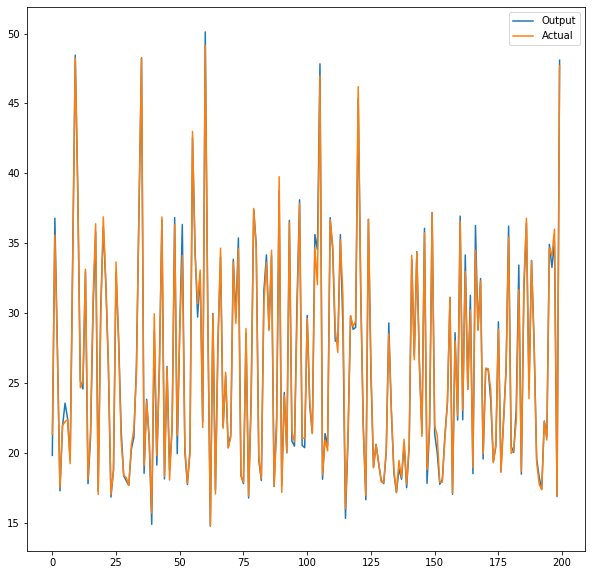

In [12]:
#Let's test model now
test(Model)

In [13]:
#Finally, let's save our model
torch.save(Model.state_dict(), './saved_models/GRU_stock.pth')

In [ ]:
#To Retrieve
Modelx = GRU(input_size=1,
        hidden_size=10,
        num_layers=2,
        output_size=1).to(device)

Modelx.load_state_dict(torch.load('./saved_models/GRU_stock.pth'))